In [6]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import json
import numpy as np
import sys
import importlib
import shutil
import math
import os
from pathlib import Path
import warnings

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation


warnings.simplefilter('ignore')

MIN_THRESHOLD = -10000000

%matplotlib inline

# First data point is the claimed performance of the model

- need to plot FROCs for GRT123 and Detection trained and evaluated on LUNA

NOTE 1: Operating points are provided by Detection so these will not be derived from data

NOTE 2: The FROC for GRT123 was never clearly published a rough guide to what was expected was shown but this included additional training from the Kaggle dataset


/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/luna_5_folds/metadata.csv
Total number of included nodule annotations: 146
Total number of nodule annotations: 1034
Cases: 889
noduleAnnots: [<evaluation.NoduleFinding object at 0x7f3cab2239a0>]
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/10

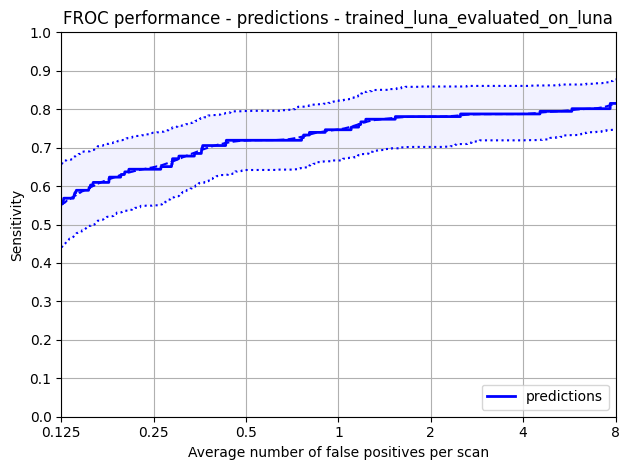

In [14]:
import pandas as pd
from pathlib import Path

cwd = '/home/jmccabe/SOTAEvaluationNoduleDetection'

def get_annotations_path(original_annotations_path, output_path):
    annotations = pd.read_csv(original_annotations_path).rename(columns={
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
    })
    annotations.to_csv(Path(output_path , 'annotations.csv'))
    return Path(output_path, 'annotations.csv')

def get_exclusions_path(original_exclusions_path, output_path):
    exclusions = pd.read_csv(original_exclusions_path).rename(columns={
        'seriesuid' : 'name',
        'coordX' : 'row',
        'coordY' : 'col',
        'coordZ' : 'index',
        'diameter_mm' : 'diameter'
    })

    exclusions.to_csv(Path(output_path , 'exclusions.csv'))
    return Path(output_path, 'exclusions.csv')

annotations_exclude_filepath = get_exclusions_path(
                                Path(cwd, 'scans/Luna16/annotations_excluded.csv'),
                                Path(cwd, 'models/grt123/bbox_result/luna_5_folds')
                            )

scanlist_filepath = Path(cwd, 'output/metadata/luna/test_fold1_scans.csv')

annotations_filepath = Path(cwd, 'models/grt123/bbox_result/luna_5_folds/metadata.csv')
predictions_filepath = Path(cwd, 'models/grt123/bbox_result/luna_5_folds/predictions.csv')

results_dir = Path(cwd, 'output/results/grt123/trained_luna/luna_5_folds')
results_dir.mkdir(parents=True, exist_ok=True)


fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename='/home/jmccabe/SOTAEvaluationNoduleDetection/scans/Luna16/pixel_exclusions.csv',
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,
    outputDir=results_dir,
    filter='trained_luna_evaluated_on_luna',
)

/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/summit/metadata.csv


Total number of included nodule annotations: 766
Total number of nodule annotations: 766
Cases: 596
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1000
computing FROC: bootstrap 23/1000
computing FROC: bootstrap 24/1000
computing FROC: bootstrap 25/1000
computing FROC: bootstrap 

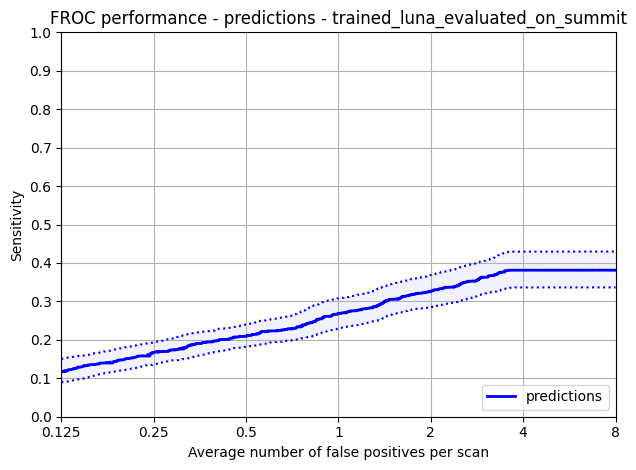

In [18]:
cwd = '/home/jmccabe/SOTAEvaluationNoduleDetection'

scanlist_filepath = Path(cwd, 'output/metadata/reduced/test_scans.csv')

annotations_filepath = Path(cwd, 'models/grt123/bbox_result/summit/metadata.csv')
predictions_filepath = Path(cwd, 'models/grt123/bbox_result/summit/predictions.csv')
annotations_exclude_filepath = Path(cwd, 'models/grt123/bbox_result/summit/exclusions.csv')

results_dir = Path(cwd, 'output/results/grt123/trained_luna/summit')
results_dir.mkdir(parents=True, exist_ok=True)


fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=annotations_exclude_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,
    outputDir=results_dir,
    filter='trained_luna_evaluated_on_summit',
)

# Detection



Set up fns to convert the detect output ... json format into predictions.csv file

In [42]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings

from sympy import use

warnings.simplefilter('ignore')

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = os.path.join(os.getcwd(), '..')

LUNA_EXCLUSIONS_PATH = Path(f'{workspace_path}/scans/luna16/metadata/annotations_excluded.csv')

metadata_path       = Path(f'{workspace_path}/output/metadata/luna')


metadata_recode = {
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
}

exclude_recode = {
    'seriesuid' : 'name',
    'coordX' : 'row',
    'coordY' : 'col',
    'coordZ' : 'index',
    'diameter_mm' : 'diameter'
}

def iou(box0, box1):
    r0 = box0[3] / 2
    s0 = box0[:3] - r0
    e0 = box0[:3] + r0

    r1 = box1[3] / 2
    s1 = box1[:3] - r1
    e1 = box1[:3] + r1

    overlap = []
    for i in range(len(s0)):
        overlap.append(max(0, min(e0[i], e1[i]) - max(s0[i], s1[i])))

    intersection = overlap[0] * overlap[1] * overlap[2]
    union = box0[3] * box0[3] * box0[3] + box1[3] * box1[3] * box1[3] - intersection
    return intersection / union

def nms(predictions, overlap_threshold=0.1):
    """
    Non-maximum suppression

    Args:
    predictions (pd.DataFrame): dataframe of predictions
    overlap_threshold (float): threshold for overlap

    Returns:
    nms_predictions (pd.DataFrame): dataframe of nms predictions
    
    """

    nms_predictions = pd.DataFrame(columns=predictions.columns)

    while len(predictions) > 0:
        max_idx = predictions['threshold'].idxmax()
        max_row = predictions.loc[max_idx]

        nms_predictions = nms_predictions.append(max_row)

        predictions = predictions.drop(max_idx)

        for idx, row in predictions.iterrows():
            
            overlap = iou(
                    max_row[['row', 'col', 'index', 'diameter']].values, 
                    row[['row', 'col', 'index', 'diameter']].values
                )
            
            if overlap > overlap_threshold:
                predictions = predictions.drop(idx)

    return nms_predictions

def get_scans_path(metadata_csv_path, results_dir, recode={}):
    scans_list = []
    for scans_path in metadata_csv_path.glob('*scans.csv'):
        scans_list.append(pd.read_csv(scans_path))

    scans = pd.concat(scans_list, ignore_index=True)
    print('Number of scans:',scans.shape)

    scans_filepath = results_dir / 'scanlist.csv'
    scans.to_csv(scans_filepath, index=False)

    return scans.seriesuid, scans_filepath    

def get_annotations_path(metadata_csv_path, results_dir, recode={}):
    """
    Convert metadata to annotation file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_filepath (str): path to annotations csv
    
    """

    annotations_list = []
    
    for metadata_csv_path in metadata_csv_path.glob('*annotations.csv'):
        annotations_list.append(pd.read_csv(metadata_csv_path).rename(columns=recode))

    annotations = pd.concat(annotations_list, ignore_index=True)
    print('Number of nodules:',annotations.shape)

    annotations_filepath = results_dir / 'annotations.csv'
    annotations.to_csv(annotations_filepath, index=False)

    return annotations_filepath

def get_exclusions_path(metadata_csv_path, scan_ids, results_dir, recode={}):
    """
    Convert metadata to exclusion file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_filepath (str): path to exclusions csv
    
    """

    exclusions = pd.read_csv(metadata_csv_path).rename(columns=recode)
    exclusions = exclusions[exclusions['name'].isin(scan_ids)]

    exclusions_filepath = results_dir / 'exclusions.csv'
    exclusions.to_csv(exclusions_filepath, index=False)

    return exclusions_filepath

def combine_predictions(predictions_json_path, results_dir, dataset_name, use_nms=True):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_list = []

    for prediction_json_path in predictions_json_path.glob('*json'):
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image_cnt, image in enumerate(predictions_json[dataset_name]):
            name = image['image'].split('/')[-1][:-7]
            
            image_predictions_dict = {}
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                image_predictions_dict[idx] = prediction
                idx+=1
            
            image_predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')
            if image_cnt == 0 and use_nms:
                print(image_predictions.shape)
                print('after nms')
                print(nms(image_predictions).shape)

            if use_nms:
                predictions_list.append(nms(image_predictions))
            else:
                predictions_list.append(image_predictions)

    predictions = pd.concat(predictions_list, ignore_index=True)
    predictions.to_csv(results_dir / 'predictions.csv', index=False)

    return results_dir / 'predictions.csv'




Number of scans: (888, 1)
Number of nodules: (1186, 5)
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/result_fold5.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/result_fold4.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/result_fold3.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/result_fold2.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/result_fold1.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm1/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
noduleAnnots: [<evaluation.NoduleFinding object at 0x136d09590>, <evaluation.NoduleFinding object at 0x136d095d0>, <evaluation.NoduleFinding object 

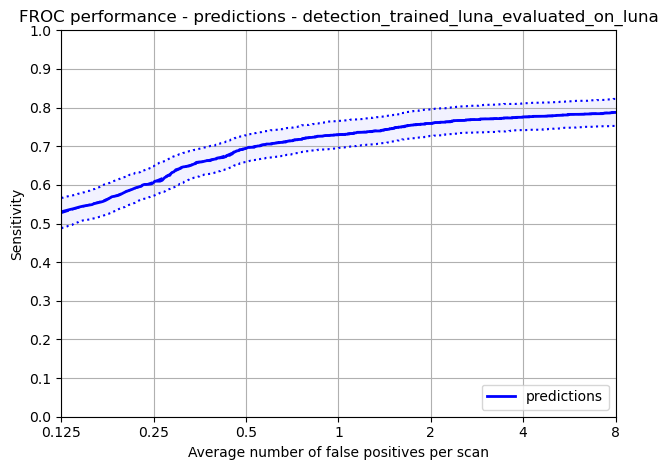

In [43]:
results_output_path = Path(f'{workspace_path}/output/results/detection/trained_luna/luna/arm1')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/LUNA/arm1')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/output/metadata/LUNA/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/output/metadata/LUNA/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='detection_trained_luna_evaluated_on_luna',
    outputDir=results_output_path
)

Number of scans: (888, 1)
Number of nodules: (1186, 5)
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/result_fold5.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/result_fold4.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/result_fold3.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/result_fold2.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/result_fold1.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/LUNA/arm2/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
noduleAnnots: [<evaluation.NoduleFinding object at 0x1361936d0>, <evaluation.NoduleFinding object at 0x136193710>, <evaluation.NoduleFinding object 

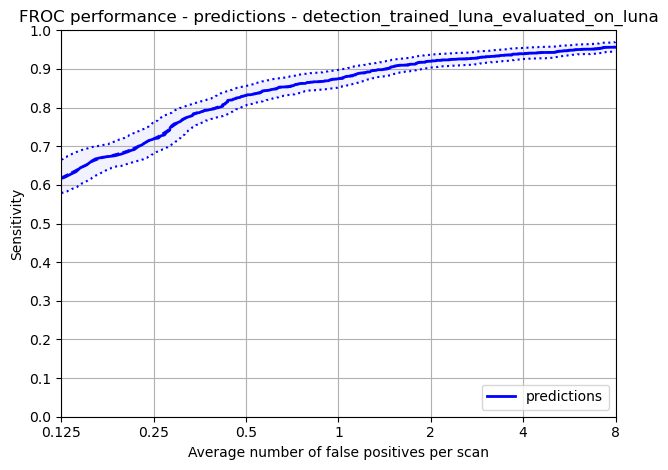

In [46]:
results_output_path = Path(f'{workspace_path}/output/results/detection/trained_luna/luna/arm2')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/LUNA/arm2')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/output/metadata/LUNA/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/output/metadata/LUNA/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='detection_trained_luna_evaluated_on_luna',
    outputDir=results_output_path
)